In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


In [2]:
# Load the yield curve data
df = pd.read_csv('yield-curve-rates-2001-2010.csv')

cols_to_drop = ['2 Mo', '4 Mo', '30 Yr'] 
df = df.drop(columns=cols_to_drop, errors='ignore')

df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df = df.dropna()

/var/folders/sv/mjqzv7js791cpqfswlr_lxp40000gn/T/ipykernel_499/3698085331.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


In [3]:

df['10 Yr_last'] = df['10 Yr'].shift(1)
df = df.dropna()
features_curve = [c for c in df.columns if c not in ['Date', '10 Yr', '10 Yr_last']]
features_lag = ['10 Yr_last']
feature_sets = {
    'Curve Only': features_curve,
    'Lag Only': features_lag,
    'Combined': features_curve + features_lag
}

In [4]:
split_idx = int(len(df) * 0.8)
train = df.iloc[:split_idx]
test = df.iloc[split_idx:]

print(f"Train size: {len(train)}, Test size: {len(test)}")

Train size: 1881, Test size: 471


In [5]:
results = []
predictions = {} # Store predictions for plotting

for name, feats in feature_sets.items():
    # Prepare X and y
    X_train = train[feats]
    y_train = train['10 Yr']
    X_test = test[feats]
    y_test = test['10 Yr']
    
    # Scale features (StandardScaler)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train Model (Ridge Regression)
    model = Ridge(alpha=1.0)
    model.fit(X_train_scaled, y_train)
    
    # Predict
    preds = model.predict(X_test_scaled)
    predictions[name] = preds
    
    # Evaluate
    r2 = r2_score(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    
    results.append({'Model': name, 'R2': r2, 'MAE': mae})

results_df = pd.DataFrame(results)
print("\nModel Performance:")
print(results_df)


Model Performance:
        Model        R2       MAE
0  Curve Only  0.940943  0.085030
1    Lag Only  0.966812  0.057309
2    Combined  0.963731  0.066582


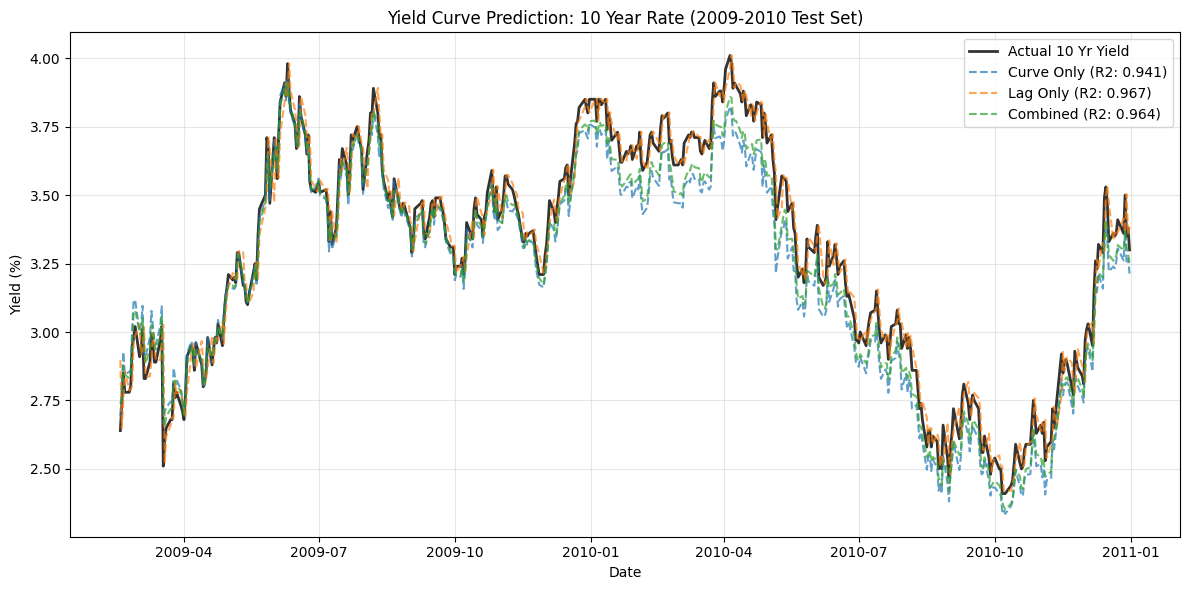

In [6]:
plt.figure(figsize=(12, 6))

plt.plot(test['Date'], test['10 Yr'], 'k-', label='Actual 10 Yr Yield', linewidth=2, alpha=0.8)

colors = ['red', 'blue', 'green']
for i, (name, preds) in enumerate(predictions.items()):
    plt.plot(test['Date'], preds, linestyle='--', label=f'{name} (R2: {results[i]["R2"]:.3f})', alpha=0.7)

plt.title('Yield Curve Prediction: 10 Year Rate (2009-2010 Test Set)')
plt.xlabel('Date')
plt.ylabel('Yield (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()